In [1]:
from petals import AutoDistributedModelForCausalLM
from transformers import AutoTokenizer, LocalAgent
import torch

In [2]:
prompt_template = """I will ask you to perform a task, your job is to come up with a series of simple commands in Python that will perform the task.
To help you, I will give you access to a set of tools that you can use. Each tool is a Python function and has a description explaining the task it performs, the inputs it expects and the outputs it returns.
You should first explain which tool you will use to perform the task and for what reason, then write the code in Python.
Each instruction in Python should be a simple assignment. You can print intermediate results if it makes sense to do so.

Tools:
<<all_tools>>

Task: "Identify the oldest person in the `document` and create an image showcasing the result."

I will use the following tools: `document_qa` to find the oldest person in the document, then `image_generator` to generate an image according to the answer.

Answer:
```py
answer = document_qa(document, question="What is the oldest person?")
print(f"The answer is {answer}.")
image = image_generator(answer)
```

I will use the following
"""

In [ ]:
model_name = "petals-team/StableBeluga2"

model = AutoDistributedModelForCausalLM.from_pretrained(
    model_name, 
    low_cpu_mem_usage=True, 
    torch_dtype=torch.float16,
    request_timeout=500,
)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False, add_bos_token=False)

agent = LocalAgent(model, tokenizer, run_prompt_template=prompt_template)

In [5]:
# this is a hack to remove all tools except the ones we want to use, because this makes agent run faster
agent._toolbox = {
    tool_name : tool for tool_name, tool in agent._toolbox.items() if tool_name in [
    "text_classifier", "image_transformer", "image_generator", "text_downloader", "translator",
]}

# Extracting key themes from a text paragraph

In [ ]:
text_paragraph = "Previous studies have shown that learning languages can help prevent Alzheimer's disease."
result_themes_extraction = agent.run(
    "Classify text on the following labels:", 
    text=text_paragraph, 
    labels=["health", "education", "politics", "technology"],
)

# Explanation from the agent
I will use the following tool: `text_classifier` to classify the text.
# Code generated by the agent
```python
label = text_classifier(text, labels)
print(f"The text is classified as {label}.")
```
# Result
We got classification successfully!

In [1]:
result_themes_extraction

health


# Generating a beautiful cover for the Bradbury book

In [ ]:
result_title_and_image = agent.run(
    "Generate a beautiful cover for book 'Fahrenheit 451' by Ray Bradbury",
)

## Explanation from the agent
I will use the following tools: `image_transformer` to modify the image, then `image_generator` to generate a new image.

## Code generated by the agent
```python
image = image_transformer(image, prompt="a beautiful cover for book 'Fahrenheit 451' by Ray Bradbury")
```

## Result
Evaluation of the code stopped at line 0 before the end because of the following error:
The variable `image` is not defined.

That is why clearly formulated instructions are important. Let's try again with a more precise prompt.

In [ ]:
result_title_and_image = agent.run(
    "Load summary of a book 'Fahrenheit 451' by Ray Bradbury and generate cover for it",
)

# Explanation from the agent
I will use the following tools: `text_downloader` to download the summary of the book, then `image_generator` to generate the cover.
# Code generated by the agent
```python
summary = text_downloader(url="https://www.goodreads.com/book/show/10.Fahrenheit_451")
print(f"Summary: {summary}")
image = image_generator(prompt="Fahrenheit 451 by Ray Bradbury")
```
# Result
We got summary and generated image successfully!

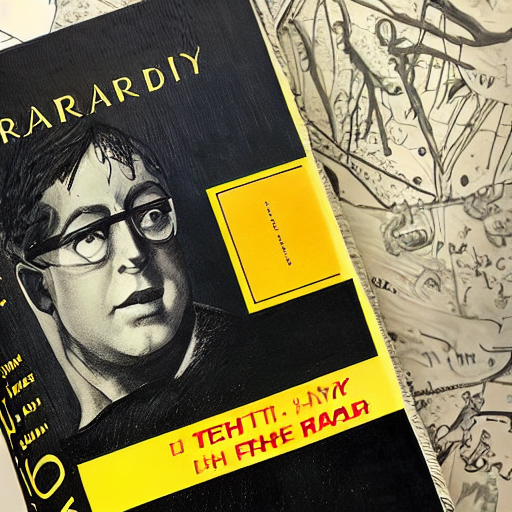

In [6]:
result_title_and_image

# Doing sentiment analysis on a customer review and translating the result in French

In [ ]:
customer_review = "I absolutely love the new features in your app!"
result_review = agent.run("Is this customer review positive, neutral, or negative, translate result in French?", text=customer_review)

# Explanation from the agent
I will use the following tools: `text_classifier` to classify the text, then `translator` to translate the result into French.
# Code generated by the agent
```python
classification = text_classifier(text=text, labels=["positive", "neutral", "negative"])
print(f"The classification is {classification}.")
translated_classification = translator(text=classification, src_lang="English", tgt_lang="French")
print(f"The translated classification is {translated_classification}.")
```
# Result
We got classification and translated classification successfully!

In [22]:
result_review

'positifs'

# Translating a phrase from Spanish and doing sentiment analysis

In [ ]:
result_sp_classification = agent.run("Is the following `text` (in Spanish) positive or negative?", text="¡Esta es una gran tecnología!")

# Explanation from the agent
I will use the following tools: `translator` to translate the text into English, then `text_classifier` to classify the text as positive or negative.
# Code generated by the agent
```python
translated_text = translator(text, "Spanish", "English")
print(f"The translated text is {translated_text}.")
label = text_classifier(text=translated_text, labels=["positive", "negative"])
print(f"The text is {label}.")
```
# Result
We got translated text and classification successfully!

In [21]:
result_sp_classification

'positive'

# Running a docker container inside a directory

In [64]:
from transformers import Tool

class DockerTool(Tool):
    name = "docker"
    description = (
        "This is a tool that runs a docker container inside a directory."
        "It takes as input the name of the docker_image as a string (`docker_image` arg) to run and the description of additional flags as a string (`flags` arg) to pass to the docker command."
        "It outputs the result of the command."
    )

    inputs = ["text"]
    outputs = ["text"]

    def __call__(self, docker_image: str, flags: str):
        import subprocess
        
        result = subprocess.run(f"docker run {docker_image} {flags}", capture_output=True, errors="ignore", shell=True)
        return result.stdout, result.stderr

In [65]:
agent = LocalAgent(model, tokenizer, additional_tools={"docker": DockerTool()})

In [ ]:
output, error = agent.run(
    "Run a docker container prod_app an all gpus with port mapping argument 5000 to 5000",
)

# Explanation from the agent
I will use the following tools: `docker` to run a docker container inside a directory.
# Code generated by the agent
```python
result = docker(docker_image="prod_app", flags="--all-gpus --port 5000:5000")
```
# Result
We got correct command!

In [70]:
error

"docker: Cannot connect to the Docker daemon at unix:///var/run/docker.sock. Is the docker daemon running?.\nSee 'docker run --help'.\n"